In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import importlib
import os
import matplotlib.patches as patches
import dask
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SGECluster
import socket
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, MaxPool2D, Conv2D, Flatten

In [96]:
hostname = socket.gethostname()
n_workers = 1
n_cores = 4

wks2 = "wn-wks2.fe.hhi.de"
gpu1 = "wn-gpu1.fe.hhi.de"
gpu2 = "wn-gpu-104-01.fe.hhi.de"

if hostname == wks2:
    path = "/data/cluster/projects/infineon-radar/daq_x-har/3_Walking_converted/recording-2020-01-28_11-31-55"
    mem = "20G"      # Allocated memory is critical. For this example it must be at least 16GB 
    q = "wn-37.q"    # Check current queue status on https://hpc-management.fe.hhi.de/wn/phpqstat/
    
    cluster = SGECluster(n_workers=n_workers, cores=n_cores, memory=mem,
                        resource_spec=f"h_vmem={mem}", host=hostname, queue=q,
                         job_extra=["-v MKL_NUM_THREADS=1,NUMEXPR_NUM_THREADS=1,OMP_NUM_THREADS=1"])
elif hostname in (gpu1, gpu2):
    path = os.getcwd() + "/data"
    os.environ["CUDA_VISIBLE_DEVICES"]="0,3"  # Check current status with nvidia-smi and pick GPU from 0-3
    cluster = LocalCluster(n_workers=n_workers, threads_per_worker=n_cores, host=hostname)
else:
    raise ValueError(f"{hostname} is not a supported host. Please run this example on {wks}, {gpu1} or {gpu2}.")
    

    
client = Client(cluster)
client.wait_for_workers(n_workers=n_workers)
client

/home/fe/khodabakhshandeh/anaconda3/envs/main-env/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.66.20.3:37086 Dashboard: http://10.66.20.3:34181/status,Cluster Workers: 1 Cores: 4 Memory: 540.49 GB


In [97]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 >= validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 < validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

def data_prep(path):
    dataset_raw = np.load(path, allow_pickle=True)
    arrays = np.array(dataset_raw[()]["data"])
    arrays = arrays - arrays.min()
    arrays = arrays/arrays.max()
    arrays -= arrays.mean()
    arrays = arrays/arrays.std()
    if np.isnan(arrays).any() or np.isinf(arrays).any():
        raise "data have imperfections"
    print(arrays.shape)
    labels = dataset_raw[()]["label"]
    labels = np.array([x-np.array(list(set(labels))).min() for x in labels])
    print(labels.shape)
    return (arrays, labels)

def load_data(path):
    data, label = data_prep(path)
    dataset = tf.data.Dataset.from_tensor_slices((data, label))
    dataset = dataset.shuffle(10000)
    train_dataset, rest = split_dataset(dataset, 0.2)
    test_dataset, valid_dataset = split_dataset(rest, 0.5)
    train_data = train_dataset.shuffle(1000).batch(10)
    valid_data = valid_dataset.batch(10)
    test_data = test_dataset.batch(10)
    return train_data, valid_data, test_data


def make_model():
    model = tf.keras.Sequential([
    Input((1,30,30)),
    Conv2D(filters = 8, kernel_size=(3,3), padding="same", activation="relu", name="c1", data_format="channels_first"),
    Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu", name="c2", data_format="channels_first"),
    MaxPool2D(pool_size=(2,2), strides=(1,1),padding="same", name="m1", data_format="channels_first"),
    
    Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu", name="c3", data_format="channels_first"),
    MaxPool2D(pool_size=(2,2), strides=(2,2),padding="valid", name="m2",data_format="channels_first"),
    
    Flatten(),
    Dense(512, activation="relu", use_bias=False),
    Dense(5,  use_bias=False)])
    return model



In [98]:
train_data, valid_data, test_data = load_data("/home/fe/khodabakhshandeh/Projects/radar/radar-ml/Python/box_data.npy")

(59003, 1, 30, 30)
(59003,)


In [39]:
#model = make_model()
print(model.summary())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(train_data, verbose=1, validation_data=valid_data, epochs=5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c1 (Conv2D)                  (None, 8, 30, 30)         80        
_________________________________________________________________
c2 (Conv2D)                  (None, 16, 30, 30)        1168      
_________________________________________________________________
m1 (MaxPooling2D)            (None, 16, 30, 30)        0         
_________________________________________________________________
c3 (Conv2D)                  (None, 16, 30, 30)        2320      
_________________________________________________________________
m2 (MaxPooling2D)            (None, 16, 15, 15)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [43]:
# model.save("base_model")
model.evaluate(test_data)

    590/Unknown - 5s 8ms/step - loss: 0.6584 - accuracy: 0.7268

[0.6584232585615147, 0.72677964]

In [99]:
model = tf.keras.models.load_model("base_model")

In [100]:
def select_random_data(train_data):
    train_data.shuffle(1000)
    _, data = split_dataset(train_data, 0.1)
    return data

def UCB1(mu, n, t):
    P = np.sqrt(2*np.log10(t)/n)
    P = P/P.max()
    print("p:", P)
    index = np.argmax(np.add(mu, P))
    return index

In [ ]:
T = 60
W = model.layers[-2].get_weights()[0]
n = np.zeros(20)
mu = np.zeros_like(n)
threshold = 0.005
for i in range(1, T):
    #select random train data for comparison
    data = select_random_data(train_data)
    
    #selecting index exploration/exploitation
    if np.where(n==0)[0].size == 0:
        index = UCB1(mu, n, i)
        print("RL")
    else:
        index = np.where(n==0)[0][0]
    
    print("index:", index)
    
    #evaluating main model
    loss_base = model.evaluate(data)[0]
    print("/n")

    
    #setting selected node to zero and evaluating again
    W_ = np.copy(W)
    W_[:, index] = 0
    model.layers[-2].set_weights([W_])
    loss = model.evaluate(data)[0]
    print("/n")
    
    #calculating delta and reward
    delta = loss_base - loss
    reward = max(0, threshold + delta)/0.1
    print("reward:", reward)
    
    #updating number of visiting the node and the average reward
    n[index] = n[index]+1
    print("n:", n)
    mu[index] = ((n[index]-1)/n[index])*mu[index] + (1/n[index])*reward
    print("mu:", mu)
    print("##############")
    #initializing the layer to the original trained weights for next round
    model.layers[-2].set_weights([W])
    
    
    

index: 0
    480/Unknown - 4s 8ms/step - loss: 0.6292 - accuracy: 0.7402/n
    480/Unknown - 4s 8ms/step - loss: 0.6579 - accuracy: 0.7231/n
reward: 0.0
n: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
##############
index: 1
    480/Unknown - 4s 7ms/step - loss: 0.6740 - accuracy: 0.7210/n
    480/Unknown - 3s 7ms/step - loss: 0.6620 - accuracy: 0.7227/n
reward: 0.16951242117599236
n: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mu: [0.         0.16951242 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
##############
index: 2
    480/Unknown - 5s 10ms/step - loss: 0.6590 - accuracy: 0.7281/n
    480/Unknown - 4s 9ms/step - loss: 0.6631 - accuracy: 0.7158/n
reward: 0.008626087987795251
n: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mu: [0.    

    480/Unknown - 4s 8ms/step - loss: 0.6564 - accuracy: 0.7271/n
reward: 0.0
n: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
mu: [0.         0.16951242 0.00862609 0.18943306 0.04415966 0.
 0.55438423 0.59785466 0.02395841 0.10579338 0.32176543 0.42822438
 0.08015762 0.02762521 0.42029861 0.         0.         0.24610997
 0.         0.        ]
##############
index: 19
    480/Unknown - 4s 7ms/step - loss: 0.6435 - accuracy: 0.7294/n
    480/Unknown - 4s 9ms/step - loss: 0.6376 - accuracy: 0.7348/n
reward: 0.10889001267981642
n: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
mu: [0.         0.16951242 0.00862609 0.18943306 0.04415966 0.
 0.55438423 0.59785466 0.02395841 0.10579338 0.32176543 0.42822438
 0.08015762 0.02762521 0.42029861 0.         0.         0.24610997
 0.         0.10889001]
##############
p: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
RL
index: 7
    480/Unknown - 3s 7ms/step - loss: 0.6636 - accuracy: 0.7277/n
    480

p: [1.         0.70710678 1.         0.70710678 1.         1.
 0.70710678 0.70710678 1.         0.70710678 0.70710678 0.70710678
 0.70710678 1.         0.70710678 1.         1.         0.70710678
 1.         0.70710678]
RL
index: 4
    480/Unknown - 4s 8ms/step - loss: 0.6244 - accuracy: 0.7427/n
    480/Unknown - 4s 8ms/step - loss: 0.6521 - accuracy: 0.7225/n
reward: 0.0
n: [1. 2. 1. 2. 2. 1. 2. 2. 1. 2. 2. 2. 2. 1. 2. 1. 1. 2. 1. 2.]
mu: [0.         0.11768025 0.00862609 0.09471653 0.02207983 0.
 0.27719212 0.29892733 0.02395841 0.21178119 0.17021563 0.29632575
 0.04007881 0.02762521 0.21366248 0.         0.         0.18514149
 0.         0.2131066 ]
##############
p: [1.         0.70710678 1.         0.70710678 0.70710678 1.
 0.70710678 0.70710678 1.         0.70710678 0.70710678 0.70710678
 0.70710678 1.         0.70710678 1.         1.         0.70710678
 1.         0.70710678]
RL
index: 13
    480/Unknown - 4s 8ms/step - loss: 0.6495 - accuracy: 0.7285/n
    480/Unknown - 4s 9ms

p: [1.         1.         1.         1.         1.         1.
 0.81649658 0.81649658 1.         1.         1.         0.81649658
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
RL
index: 14
    480/Unknown - 3s 5ms/step - loss: 0.6791 - accuracy: 0.7225- 2s 6ms/step - loss: 0.7096 - accurac - 3s 5ms/step - loss: 0.6/n
    480/Unknown - 3s 7ms/step - loss: 0.6326 - accuracy: 0.7292/n
reward: 0.5152514152112418
n: [2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2. 3. 2. 2. 3. 2. 2. 2. 2. 2.]
mu: [0.         0.11768025 0.07445872 0.09471653 0.02207983 0.13474508
 0.18479474 0.19928489 0.01197921 0.21178119 0.17021563 0.2108382
 0.04007881 0.01381261 0.31419213 0.1369321  0.         0.18514149
 0.02828143 0.2131066 ]
##############
p: [1.         1.         1.         1.         1.         1.
 0.81649658 0.81649658 1.         1.         1.         0.81649658
 1.         1.         0.81649658 1.         1.         1.
 1.         1.        ]
RL
index: 19
    480/Unknown - 4

p: [1.         0.81649658 0.81649658 0.81649658 1.         0.81649658
 0.81649658 0.81649658 1.         0.81649658 0.81649658 0.81649658
 0.81649658 1.         0.70710678 0.81649658 1.         0.81649658
 1.         0.81649658]
RL
index: 18
    360/Unknown - 2s 6ms/step - loss: 0.8114 - accuracy: 0.6592

In [102]:
n

array([3., 3., 4., 2., 3., 3., 3., 2., 3., 3.])

In [103]:
mu

array([0.08734847, 0.09009925, 0.17142199, 0.        , 0.2195965 ,
       0.05465102, 0.15269722, 0.        , 0.16692901, 0.11539575])

[1.         0.70710678 0.57735027 0.5        0.4472136  0.40824829
 0.37796447 0.35355339 0.33333333 0.31622777 0.30151134 0.28867513
 0.2773501  0.26726124 0.25819889 0.25       0.24253563 0.23570226
 0.22941573 0.2236068  0.21821789 0.21320072 0.20851441 0.20412415
 0.2        0.19611614 0.19245009 0.18898224 0.18569534 0.18257419
 0.1796053  0.1767767  0.17407766 0.17149859 0.16903085 0.16666667
 0.16439899 0.16222142 0.16012815 0.15811388 0.15617376 0.15430335
 0.15249857 0.15075567 0.1490712  0.14744196 0.14586499 0.14433757
 0.14285714 0.14142136 0.14002801 0.13867505 0.13736056 0.13608276
 0.13483997 0.13363062 0.13245324 0.13130643 0.13018891 0.12909944
 0.12803688 0.12700013 0.12598816 0.125      0.12403473 0.12309149
 0.12216944 0.12126781 0.12038585 0.11952286 0.11867817 0.11785113
 0.11704115 0.11624764 0.11547005 0.11470787 0.11396058 0.1132277
 0.11250879 0.1118034  0.11111111 0.11043153 0.10976426 0.10910895
 0.10846523 0.10783277 0.10721125 0.10660036 0.10599979 0.10540

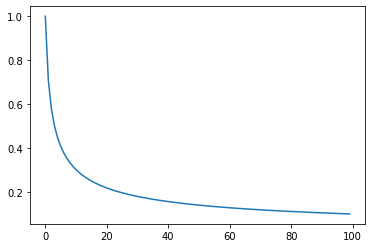

In [84]:
a = np.arange(100)+1
t = sum(a)
p=np.sqrt(2*np.log10(t)/a)
pp = p/p.max()
print(pp)
plt.plot(pp)

In [70]:
p+m

array([2.6130902 , 1.93131806, 1.65854132, 1.93131806, 1.60969079])

In [67]:
mu[argmax(mu)]

NameError: name 'argmax' is not defined

In [92]:
a = np.array([1,2,3,3,2,1,1,1])
a[2] +=1

In [93]:
a

array([1, 2, 4, 3, 2, 1, 1, 1])